# Otoliths predictions

In [1]:
%matplotlib inline 
from util.useful_imports import *

## Exploratory analysis

** Load images from the root folder... **

In [2]:
loader = ImageFolder(root=ROOT_DIR)
label_map = dict({loader.class_to_idx[name]: name for name in loader.classes})

In [3]:
# print statitics
print('There are {} different labels:\n'.format(len(loader.classes)))
for label in loader.classes:
    print('{}'.format(label))

There are 6 different labels:

Dikkop
Haring
Kleine zandspiering
Smelt
Sprot
Wijting


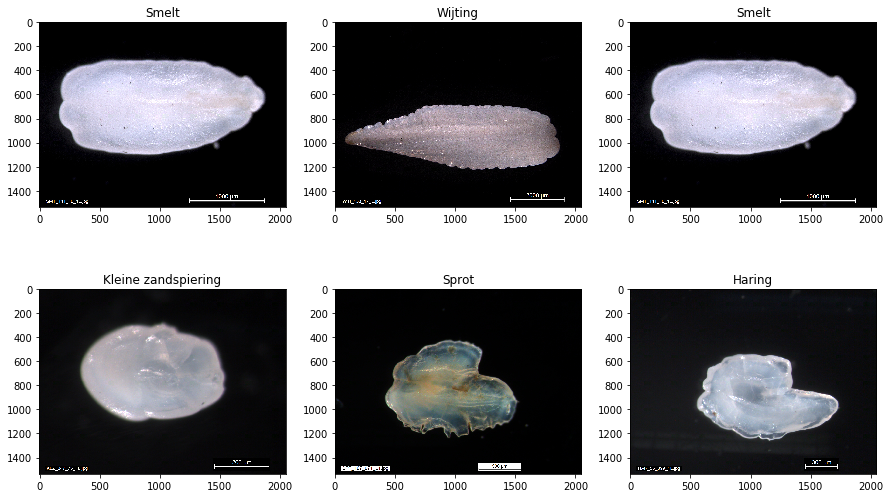

In [4]:
nrows, ncols = 2, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,9))

for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(1,len(loader))
        axs[i,j].imshow(loader[idx][0])
        axs[i,j].set_title(label_map[loader[idx][1]])

# Images
**Look closer to an individual image...**

One image has size of 2048x1536


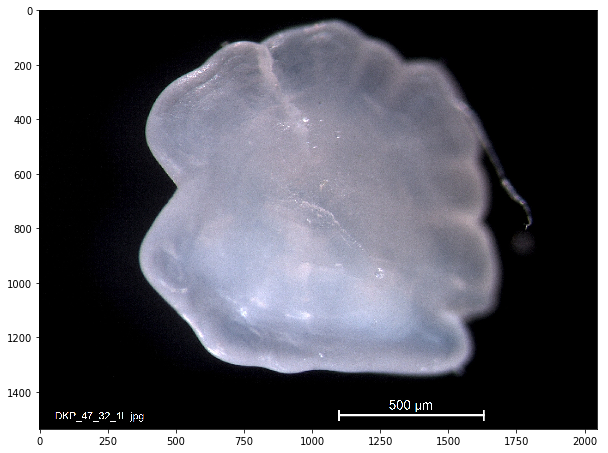

In [5]:
width, height = loader[1][0].size
print("One image has size of {}x{}".format(width, height))
plt.figure(figsize=(10,10))
plt.imshow(loader[0][0])

# Data processing

### Removing meta-info
** Data augmentation **
* Random Flip
* Random Rotation (-45,+45)
* Random Vertical Flip
* Random Horizontal Flip

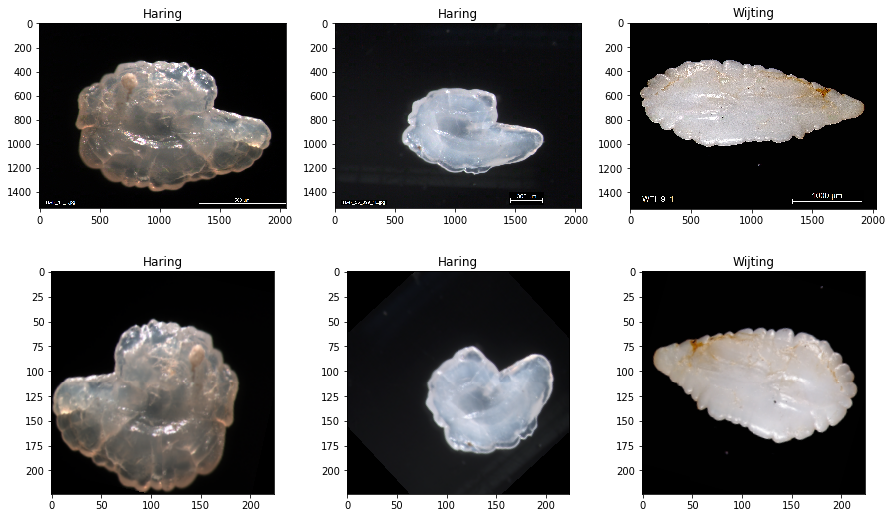

In [6]:
import PIL
data = ImageFolder(root=ROOT_DIR, 
                   transform=
                       transforms.Compose([
                           transforms.Lambda(lambda x: ut.crop_img(x, 2000, 1400)),
                           transforms.Resize((224, 224)),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomVerticalFlip(),
                           transforms.RandomRotation(45,PIL.Image.BILINEAR)])
                          )

nrows, ncols = 2, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,9))

for j in range(ncols):
    idx = random.randint(0,len(loader)-1)
    axs[0,j].imshow(loader[idx][0])
    axs[0,j].set_title(label_map[loader[idx][1]])
    axs[1,j].imshow(data[idx][0])
    axs[1,j].set_title(label_map[data[idx][1]])  

# Problems
* **Mismatched training and test distributions ** (training images are high-resolution images)